In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
import random
import warnings
warnings.filterwarnings(action='ignore')

## Hyperparameter Settings

In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LR':0.01,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed Random-Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Load Data

In [ ]:
# Example Data
train_data_ex = pd.read_csv('/content/drive/MyDrive/Tave_Project_MultiModal/Data/ex_data/ex_train.csv')
test_data_ex = pd.read_csv('/content/drive/MyDrive/Tave_Project_MultiModal/Data/ex_data/ex_test.csv')

# Real Data
train_data = pd.read_csv('/content/drive/MyDrive/Tave_Project_MultiModal/Data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Tave_Project_MultiModal/Data/test.csv')

print('example train data shape : ', train_data_ex.shape)
print('example test data shape : ', test_data_ex.shape)
print('raw train data shape : ', train_data.shape)
print('raw test data shape : ', test_data.shape)

example train data shape :  (10, 4)
example test data shape :  (10, 2)
raw train data shape :  (74568, 4)
raw test data shape :  (13012, 2)


이미지 너비:720, 이미지 높이:467


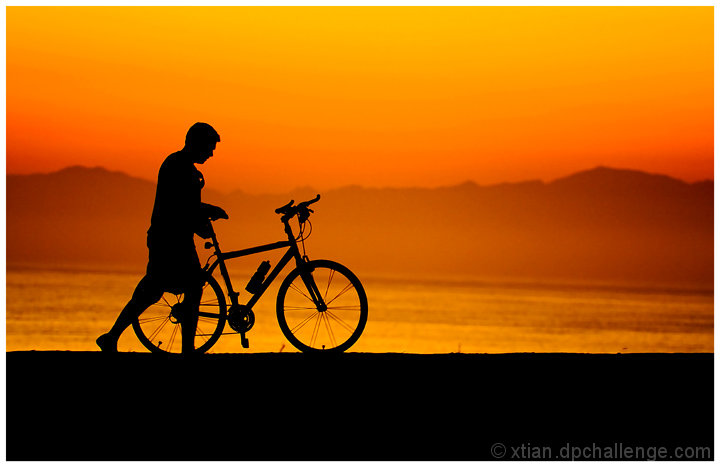

In [ ]:
def load_jpg_image(file_path):
    image = Image.open(file_path)
    width, height = image.size
    print(f'이미지 너비:{width}, 이미지 높이:{height}')
    return image

jpg_path = '/content/drive/MyDrive/Tave_Project_MultiModal/Data/ex_data/ex_train/0a0nbjgefy.jpg'
load_image = load_jpg_image(jpg_path)
load_image

## Preprocess Dataset

- Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # mos column 존재 여부에 따라 값을 설정
        mos = float(self.dataframe.iloc[idx]['mos']) if 'mos' in self.dataframe.columns else 0.0
        comment = self.dataframe.iloc[idx]['comments'] if 'comments' in self.dataframe.columns else ""

        return img, mos, comment

- Convert Data Path for Colab

In [ ]:
# Loading Data
train_data_raw = pd.read_csv('/content/drive/MyDrive/Tave_Project_MultiModal/Data/contest_train.csv')
test_data_raw = pd.read_csv('/content/drive/MyDrive/Tave_Project_MultiModal/Data/contest_test.csv')

# Convert Data path
train_data_raw['img_path'] = train_data_raw['img_path'].str[8:]
train_data_raw['img_path'] = '/content/drive/MyDrive/Tave_Project_MultiModal/Data/train/' + train_data_raw['img_path']
test_data_raw['img_path'] = test_data_raw['img_path'].str[7:]
test_data_raw['img_path'] = '/content/drive/MyDrive/Tave_Project_MultiModal/Data/test/' + test_data_raw['img_path']

# Save Data
# train_data_raw.to_csv('train_data.csv', index = False)
# test_data_raw.to_csv('test_data.csv', index = False)

## Define Model

In [ ]:
class BaseModel(nn.Module):
    # 생성자 메서드: 어휘 크기, 임베딩 차원, 히든 차원 초기화
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512):
        super(BaseModel, self).__init__()

        # 이미지 특성 추출
        self.cnn_backbone = models.resnet50(pretrained=True) # ResNet50
        # self.cnn_backbone = models.mobilenet_v3_small(pretrained=True) # Mobilenet_v3
        # 마지막 완전 연결 레이어를 제거하여 특성을 얻음
        modules = list(self.cnn_backbone.children())[:-1]
        self.cnn = nn.Sequential(*modules)

        # Image quality assessment head
        self.regression_head = nn.Linear(2048, 1) # ResNet50:2048 features
        # self.regression_head = nn.Linear(576, 1) # Moblienet: 576 features
        # Captioning head
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # 이미지 특성과 캡션 임베딩을 입력으로 받음
        self.lstm = nn.LSTM(embed_dim + 2048, hidden_dim) # ResNet50 + LSTM
        # self.gru = nn.GRU(embed_dim + 2048, hidden_dim) # ResNet50 + GRU
        # self.lstm = nn.LSTM(embed_dim + 576, hidden_dim) # Mobilenet_v3 + LSTM
        # self.gru = nn.GRU(embed_dim + 576, hidden_dim) # Mobilenet_v3 + GRU
        self.fc = nn.Linear(hidden_dim, vocab_size)

    # 순전파 메서드 정의
    def forward(self, images, captions=None):
        # CNN
        features = self.cnn(images)
        # 주어진 특성을 2D 텐서 -> 1D 텐서(하나의 벡터)로 변환
        features_flat = features.view(features.size(0), -1)
        # Image quality regression
        mos = self.regression_head(features_flat)

        # Image captioning
        if captions is not None:
            embeddings = self.embedding(captions)
            # 이미지 특성과 캡션 임베딩을 각 단어에 대해 연결
            combined = torch.cat([features_flat.unsqueeze(1).repeat(1, embeddings.size(1), 1), embeddings], dim=2)

            # Caption Layer
            lstm_out, _ = self.lstm(combined) # Caption : LSTM
            # gru_out, _ = self.gru(combined) # Caption : GRU

            # OUTPUT
            outputs = self.fc(lstm_out) # Caption : LSTM
            # outputs = self.fc(gru_out) # Caption : GRU
            return mos, outputs
        else:
            return mos, None

In [ ]:
# 단어 사전 생성
all_comments = ' '.join(train_data['comments']).split()
vocab = set(all_comments)
vocab = ['<PAD>', '<SOS>', '<EOS>'] + list(vocab)
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# 데이터셋 및 DataLoader 생성
transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])
train_dataset = CustomDataset(train_data, transform)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

# 모델, 손실함수, 옵티마이저
model = BaseModel(len(vocab)).cuda()
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.0MB/s]


In [ ]:
# 학습
model.train()
for epoch in range(CFG['EPOCHS']):
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for imgs, mos, comments in loop:
        imgs, mos = imgs.float().cuda(), mos.float().cuda()

        # Batch Preprocessing
        comments_tensor = torch.zeros((len(comments), len(max(comments, key=len)))).long().cuda()
        for i, comment in enumerate(comments):
            tokenized = ['<SOS>'] + comment.split() + ['<EOS>']
            comments_tensor[i, :len(tokenized)] = torch.tensor([word2idx[word] for word in tokenized])

        # Forward & Loss
        predicted_mos, predicted_comments = model(imgs, comments_tensor)
        loss1 = criterion1(predicted_mos.squeeze(1), mos)
        loss2 = criterion2(predicted_comments.view(-1, len(vocab)), comments_tensor.view(-1))
        loss = loss1 + loss2

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} finished with average loss: {total_loss / len(train_loader):.4f}")

Epoch 1: 100%|██████████| 1/1 [00:10<00:00, 10.65s/it, loss=42.8]


Epoch 1 finished with average loss: 42.7904


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, loss=7.18]


Epoch 2 finished with average loss: 7.1784


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, loss=5.52]


Epoch 3 finished with average loss: 5.5162


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, loss=11.6]


Epoch 4 finished with average loss: 11.5879


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, loss=4.75]


Epoch 5 finished with average loss: 4.7544


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, loss=3.63]


Epoch 6 finished with average loss: 3.6268


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, loss=2.96]


Epoch 7 finished with average loss: 2.9590


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, loss=2.56]


Epoch 8 finished with average loss: 2.5638


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s, loss=2.16]


Epoch 9 finished with average loss: 2.1571


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s, loss=1.73]

Epoch 10 finished with average loss: 1.7288


## Inference & Submit

In [ ]:
test_dataset = CustomDataset(test_data, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predicted_mos_list = []
predicted_comments_list = []

def greedy_decode(model, image, max_length=50):
    image = image.unsqueeze(0).cuda()
    mos, _ = model(image)
    output_sentence = []

    # 시작 토큰 설정
    current_token = torch.tensor([word2idx['<SOS>']]).cuda()
    hidden = None
    features = model.cnn(image).view(image.size(0), -1)

    for _ in range(max_length):
        embeddings = model.embedding(current_token).unsqueeze(0)
        combined = torch.cat([features.unsqueeze(1), embeddings], dim=2)
        out, hidden = model.lstm(combined, hidden)

        output = model.fc(out.squeeze(0))
        _, current_token = torch.max(output, dim=1)

        # <EOS> 토큰에 도달하면 멈춤
        if current_token.item() == word2idx['<EOS>']:
            break

        # <SOS> 또는 <PAD> 토큰은 생성한 캡션에 추가하지 않음
        if current_token.item() not in [word2idx['<SOS>'], word2idx['<PAD>']]:
            output_sentence.append(idx2word[current_token.item()])

    return mos.item(), ' '.join(output_sentence)

# 추론 과정
with torch.no_grad():
    for imgs, _, _ in tqdm(test_loader):
        for img in imgs:
            img = img.float().cuda()
            mos, caption = greedy_decode(model, img)
            predicted_mos_list.append(mos)
            predicted_comments_list.append(caption)

# 결과 저장
result_df = pd.DataFrame({
    'img_name': test_data['img_name'],
    'mos': predicted_mos_list,
    'comments': predicted_comments_list  # 캡션 부분은 위에서 생성한 것을 사용
})

# 예측 결과에 NaN이 있다면, 제출 시 오류가 발생하므로 후처리 진행 (sample_submission.csv과 동일하게)
result_df['comments'] = result_df['comments'].fillna('Nice Image.')
result_df.to_csv('/content/drive/MyDrive/Tave_Project_MultiModal/Data/ex_data/submit.csv', index=False)

print("Inference completed and results saved to submit.csv.")

100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

Inference completed and results saved to submit.csv.
